## What Will We Cover?
In the following, we will investigate three approaches to clustering the data:

- Kmeans
- K-Prototype
- LLM combined with K-means

### Loading, Exploring and preprocessing data

Loading and preprocessing data involve several steps to prepare the data for analysis or modeling

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Load data

In [2]:
# import pandas as pd
# file_path = "/content/drive/MyDrive/SRTR/tx_li.csv"
# df = pd.read_csv(file_path)
import pandas as pd
df = pd.read_csv("data/tx_li.csv")
print(df.shape)

/var/folders/gx/4hmfp0zd12bblv6znjwbmv600000gn/T/ipykernel_69986/923499338.py:5: DtypeWarning: Columns (35,36,38,39,40,88,115,116,122,139,140,153,159,170,192,195,196,201,202,203,204,206,208,210,212,215,219,220,221,227,230,236,277) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/tx_li.csv")


(136542, 310)


In [3]:
df['TFL_LASTATUS']

0         b'D'
1         b'A'
2         b'A'
3         b'A'
4         b'D'
          ... 
136537    b'A'
136538    b'A'
136539    b'A'
136540    b'A'
136541    b'A'
Name: TFL_LASTATUS, Length: 136542, dtype: object

#### Exploring data

In [4]:
print(df.shape)

(136542, 310)


In [5]:
# Define the list of desired values: Inclusion criteria of all patients with diagnosis of Cirrhosis
values = [4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4212,
         4213, 4214, 4215, 4216, 4220, 4230, 4231, 4235, 4240, 4241, 4242, 4245]

# Filter the dataframe
df = df[df['REC_DGN'].isin(values)]


In [6]:
print(df.shape)

(95769, 310)


#### Select appropriate records

In [7]:
#removing patients younger than 18
df = df[df['REC_AGE_AT_TX'] > 17]


In [8]:
print(df.shape)

(95769, 310)


In [9]:
#removing patients who had previous transplants
df = df[df['CAN_PREV_TX'] != 1]


In [10]:
print(df.shape)

(91139, 310)


#### Clean data

In [11]:
#Cleaning the categorical data, and simplyfing them
import pandas as pd

# CAN_ABO
df['CAN_ABO'] = df['CAN_ABO'].replace({'A1': 'A', 'A2': 'A', 'A1B': 'AB', 'A2B': 'AB'})

# CAN_ANGINA
df['CAN_ANGINA'] = df['CAN_ANGINA'].replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 30: 1, 998: 'Unknown'})

# CAN_ANGINA_CAD
df['CAN_ANGINA_CAD'] = df['CAN_ANGINA_CAD'].replace({1: 0, 2: 1, 3: 1, 4: 1, 998: 'Unknown'})

# CAN_DIAB
df['CAN_DIAB'] = df['CAN_DIAB'].replace({1: 0, 2: 1, 3: 1, 4: 1, 998: 'Unknown'})

# CAN_DIAB_TY
df['CAN_DIAB_TY'] = df['CAN_DIAB_TY'].replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 998: 'Unknown'})

# CAN_GENDER
df['CAN_GENDER'] = df['CAN_GENDER'].replace({b'M': 'Male', b'F': 'Female'})

# REC_FUNCTN_STAT
rec_functn_stat_map = {1: 'Needs no assistance', 2080: 'Needs no assistance', 2090: 'Needs no assistance', 2100: 'Needs no assistance',
                       2: 'Needs some assistance', 2070: 'Needs some assistance', 2060: 'Needs some assistance', 2050: 'Needs some assistance',
                       3: 'Needs total assistance', 2040: 'Needs total assistance', 2030: 'Needs total assistance', 2020: 'Needs total assistance', 2010: 'Needs total assistance',
                       998: 'Unknown'}
df['REC_FUNCTN_STAT'] = df['REC_FUNCTN_STAT'].map(rec_functn_stat_map)

# CAN_LAST_ASCITES
df['CAN_LAST_ASCITES'] = df['CAN_LAST_ASCITES'].replace({1: 'No ascites', 2: 'Mild ascites', 3: 'Moderate ascites', 4: 'Unknown'})

# CAN_LAST_ENCEPH
df['CAN_LAST_ENCEPH'] = df['CAN_LAST_ENCEPH'].replace({1: 0, 2: 1, 3: 1, 4: 'Unknown'})

# CAN_PEPTIC_ULCER
df['CAN_PEPTIC_ULCER'] = df['CAN_PEPTIC_ULCER'].replace({1: 0, 2: 1, 3: 1, 4: 1, 998: 'Unknown'})

# CAN_RACE
race_map = {8: 'White', 16: 'Black', 32: 'Native American', 64: 'Asian', 512: 'Indian', 2000: 'Other', 128: 'Other', 256: 'Other'}
df['CAN_RACE'] = df['CAN_RACE'].map(race_map)

# DON_HIST_CANCER
df['DON_HIST_CANCER'] = df['DON_HIST_CANCER'].apply(lambda x: 0 if x == 1 else (1 if x != 998 else 'unknown'))

# DON_HIST_DIAB
df['DON_HIST_DIAB'] = df['DON_HIST_DIAB'].replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 998: 'unknown'})

# DON_HIST_HYPERTEN
df['DON_HIST_HYPERTEN'] = df['DON_HIST_HYPERTEN'].replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 998: 'unknown'})

# DON_TY
df['DON_TY'] = df['DON_TY'].replace({b'C': 0, b'L': 1})

# REC_DGN
rec_dgn_map = {4202: 'Hepatitis B', 4207: 'Hepatitis B', 4204: 'Hepatitis C', 4206: 'Hepatitis B & C', 4216: 'Hepatitis C & Alcohol',
               4212: 'Autoimmune', 4214: 'Fatty Liver', 4215: 'Alcohol', 4220: 'PBC',
               4235: 'PSC', 4240: 'PSC', 4241: 'PSC', 4242: 'PSC', 4245: 'PSC', 4208: 'Cryptogenic', 4213: 'Cryptogenic'}
df['REC_DGN'] = df['REC_DGN'].map(rec_dgn_map).fillna('Others')

# REC_MED_COND
df['REC_MED_COND'] = df['REC_MED_COND'].replace({1: 'Patient needed to be in intensive care unit', 2: 'Patient needed to be in regular hospital room', 3: 'Patient was at home'})

# REC_VENTILATOR
df['REC_VENTILATOR'] = df['REC_VENTILATOR'].replace({0: 'No', 1: 'Yes'})



#### Select features

In [12]:
# Keeping only the variables of interest for prediction
cols_to_keep = [
    'REC_AGE_AT_TX', 'CAN_PREV_TX', 'TFL_DEATH_DT', 'REC_TX_DT', 'TFL_COD', 'CAN_ABO',
    'CAN_ANGINA', 'CAN_ANGINA_CAD', 'CAN_DIAB', 'CAN_DIAB_TY', 'CAN_GENDER', 'REC_FUNCTN_STAT', 'CAN_LAST_ASCITES',
    'CAN_PEPTIC_ULCER', 'CAN_RACE', 'DON_HIST_CANCER', 'DON_HIST_DIAB', 'DON_HIST_HYPERTEN', 'DON_TY',
    'REC_DGN', 'REC_MED_COND', 'REC_VENTILATOR', 'CAN_HGT_CM', 'CAN_LAST_ALBUMIN', 'CAN_LAST_BILI',
    'CAN_LAST_INR', 'CAN_LAST_SERUM_CREAT', 'CAN_LAST_SERUM_SODIUM', 'CAN_WGT_KG', 'DON_AGE_IN_MONTHS',
    'DON_WARM_ISCH_TM_MINS', 'DON_WGT_KG', 'CAN_BACTERIA_PERIT', 'CAN_CEREB_VASC', 'CAN_DRUG_TREAT_COPD',
    'CAN_DRUG_TREAT_HYPERTEN', 'CAN_LAST_DIAL_PRIOR_WEEK', 'REC_INOTROP_BP_SUPPORT', 'REC_MALIG',
    'CAN_PERIPH_VASC', 'CAN_PORTAL_VEIN', 'CAN_PREV_ABDOM_SURG', 'CAN_PULM_EMBOL', 'CAN_TIPSS',
    'DON_MEET_CDC_HIGH_RISK', 'REC_PORTAL_HYPERTEN_BLEED', 'REC_VARICEAL_BLEEDING', 'CAN_LAST_SRTR_LAB_MELD', 'TFL_LAFUDATE',
    'TFL_LASTATUS'
]

# Drop columns not in the list
df = df[cols_to_keep]


In [13]:
print(df.shape)

(91139, 50)


#### Mapping data

In [14]:
# Simplifying the causes of death into broader categories
mappings = {
    'Unknown': [998, 2804, 3916, 3917, 4959, 4960, 5816],
    'Other': [999, 3902, 3906, 4940, 4941, 4942, 4945, 4950, 2712, 4615, 4951, 4952, 4953, 4954, 4900, 4910],
    'Graft failure': [2000, 2004, 2099, 3200, 3201, 3204, 3299, 3915, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4610, 4955, 4956, 4957, 4958],
    'Infection': [2100, 2101, 2109, 2112, 2129, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3399, 4800, 4801, 4802, 4803, 4804, 4805, 4806, 4810, 4811, 6755, 6798],
    'Cardiovascular': [2201, 2203, 2209, 3400, 3401, 3499, 4246, 4620, 4621, 4622, 4623, 4624, 4625, 4626],
    'Respiratory failure': [2304, 2305, 2399, 3904, 4640, 4645],
    'Cerebrovascular': [2400, 2401, 2402, 3500, 3599, 4630, 4631, 4635, 4701],
    'GI bleeding': [2501, 3600, 4700, 4702],
    'Bleeding': [3601, 3699, 3901, 4703, 4705, 4706],
    'Malignancy': [2600, 2602, 2699, 3700, 3701, 3702, 3799, 4850, 4851, 4855, 4856, 4860],
    'Liver failure': [2704, 3907],
    'MOF': [2705, 3908, 4660, 5809],
    'PE': [3402, 4247],
    'Trauma': [3800, 3899, 4930, 4935],
    'Renal failure': [3903, 4650, 5805],
    'Suicide': [3905, 4920]
}

# Create a reverse mapping
reverse_mapping = {code: category for category, codes in mappings.items() for code in codes}

# Replace values in TFL_COD column
df['TFL_COD'] = df['TFL_COD'].replace(reverse_mapping)


In [15]:
# Convert the columns to datetime format with explicit DD/MM/YYYY format
df['TFL_DEATH_DT'] = pd.to_datetime(df['TFL_DEATH_DT'], format='%d/%m/%Y')
df['REC_TX_DT'] = pd.to_datetime(df['REC_TX_DT'], format='%d/%m/%Y')
df['TFL_LAFUDATE'] = pd.to_datetime(df['TFL_LAFUDATE'], format='%d/%m/%Y')

# Create the TX_SURV column
df['TX_SURV'] = df.apply(lambda row: (row['TFL_DEATH_DT'] - row['REC_TX_DT']).days if pd.notnull(row['TFL_DEATH_DT'])
                         else (row['TFL_LAFUDATE'] - row['REC_TX_DT']).days, axis=1)


In [16]:
#Cleaning the MELD score: only keeping the last 2 variables
df['CAN_LAST_SRTR_LAB_MELD'] = df['CAN_LAST_SRTR_LAB_MELD'] % 100


In [17]:
df.head()

,REC_AGE_AT_TX,CAN_PREV_TX,TFL_DEATH_DT,REC_TX_DT,TFL_COD,CAN_ABO,CAN_ANGINA,CAN_ANGINA_CAD,CAN_DIAB,CAN_DIAB_TY,...,CAN_PREV_ABDOM_SURG,CAN_PULM_EMBOL,CAN_TIPSS,DON_MEET_CDC_HIGH_RISK,REC_PORTAL_HYPERTEN_BLEED,REC_VARICEAL_BLEEDING,CAN_LAST_SRTR_LAB_MELD,TFL_LAFUDATE,TFL_LASTATUS,TX_SURV
1,55,0,NaT,2012-11-25,NaN,b'O',NaN,0.0,NaN,0.0,...,b'N',b'N',b'N',b'N',b'N',NaN,22.0,2022-12-02,b'A',3659
4,52,0,2019-07-19,2012-12-24,Cardiovascular,b'A',NaN,0.0,NaN,1.0,...,b'Y',b'N',b'N',b'N',b'N',NaN,23.0,2019-07-19,b'D',2398
5,46,0,NaT,2012-11-06,NaN,b'O',NaN,0.0,NaN,1.0,...,b'Y',b'N',b'N',b'N',b'N',NaN,27.0,2022-10-03,b'A',3618
6,62,0,NaT,2012-11-26,NaN,b'O',NaN,0.0,NaN,1.0,...,b'Y',b'N',b'Y',b'N',b'N',NaN,9.0,2022-07-15,b'A',3518
7,54,0,NaT,2012-10-20,NaN,b'B',NaN,0.0,NaN,0.0,...,b'Y',b'N',b'N',b'Y',b'N',NaN,20.0,2022-09-28,b'A',3630


In [18]:
#checking missing values
missing_values = df.isnull().sum()
print(missing_values)


REC_AGE_AT_TX                    0
CAN_PREV_TX                      0
TFL_DEATH_DT                 65642
REC_TX_DT                        0
TFL_COD                      65645
CAN_ABO                          0
CAN_ANGINA                   83273
CAN_ANGINA_CAD               56851
CAN_DIAB                     83273
CAN_DIAB_TY                     22
CAN_GENDER                       0
REC_FUNCTN_STAT               2197
CAN_LAST_ASCITES                 1
CAN_PEPTIC_ULCER             48990
CAN_RACE                       443
DON_HIST_CANCER                  0
DON_HIST_DIAB                 4502
DON_HIST_HYPERTEN             4502
DON_TY                           0
REC_DGN                          0
REC_MED_COND                   472
REC_VENTILATOR                   0
CAN_HGT_CM                     189
CAN_LAST_ALBUMIN                 1
CAN_LAST_BILI                    1
CAN_LAST_INR                     1
CAN_LAST_SERUM_CREAT             1
CAN_LAST_SERUM_SODIUM         7302
CAN_WGT_KG          

#### Visualizing the chosen features 

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

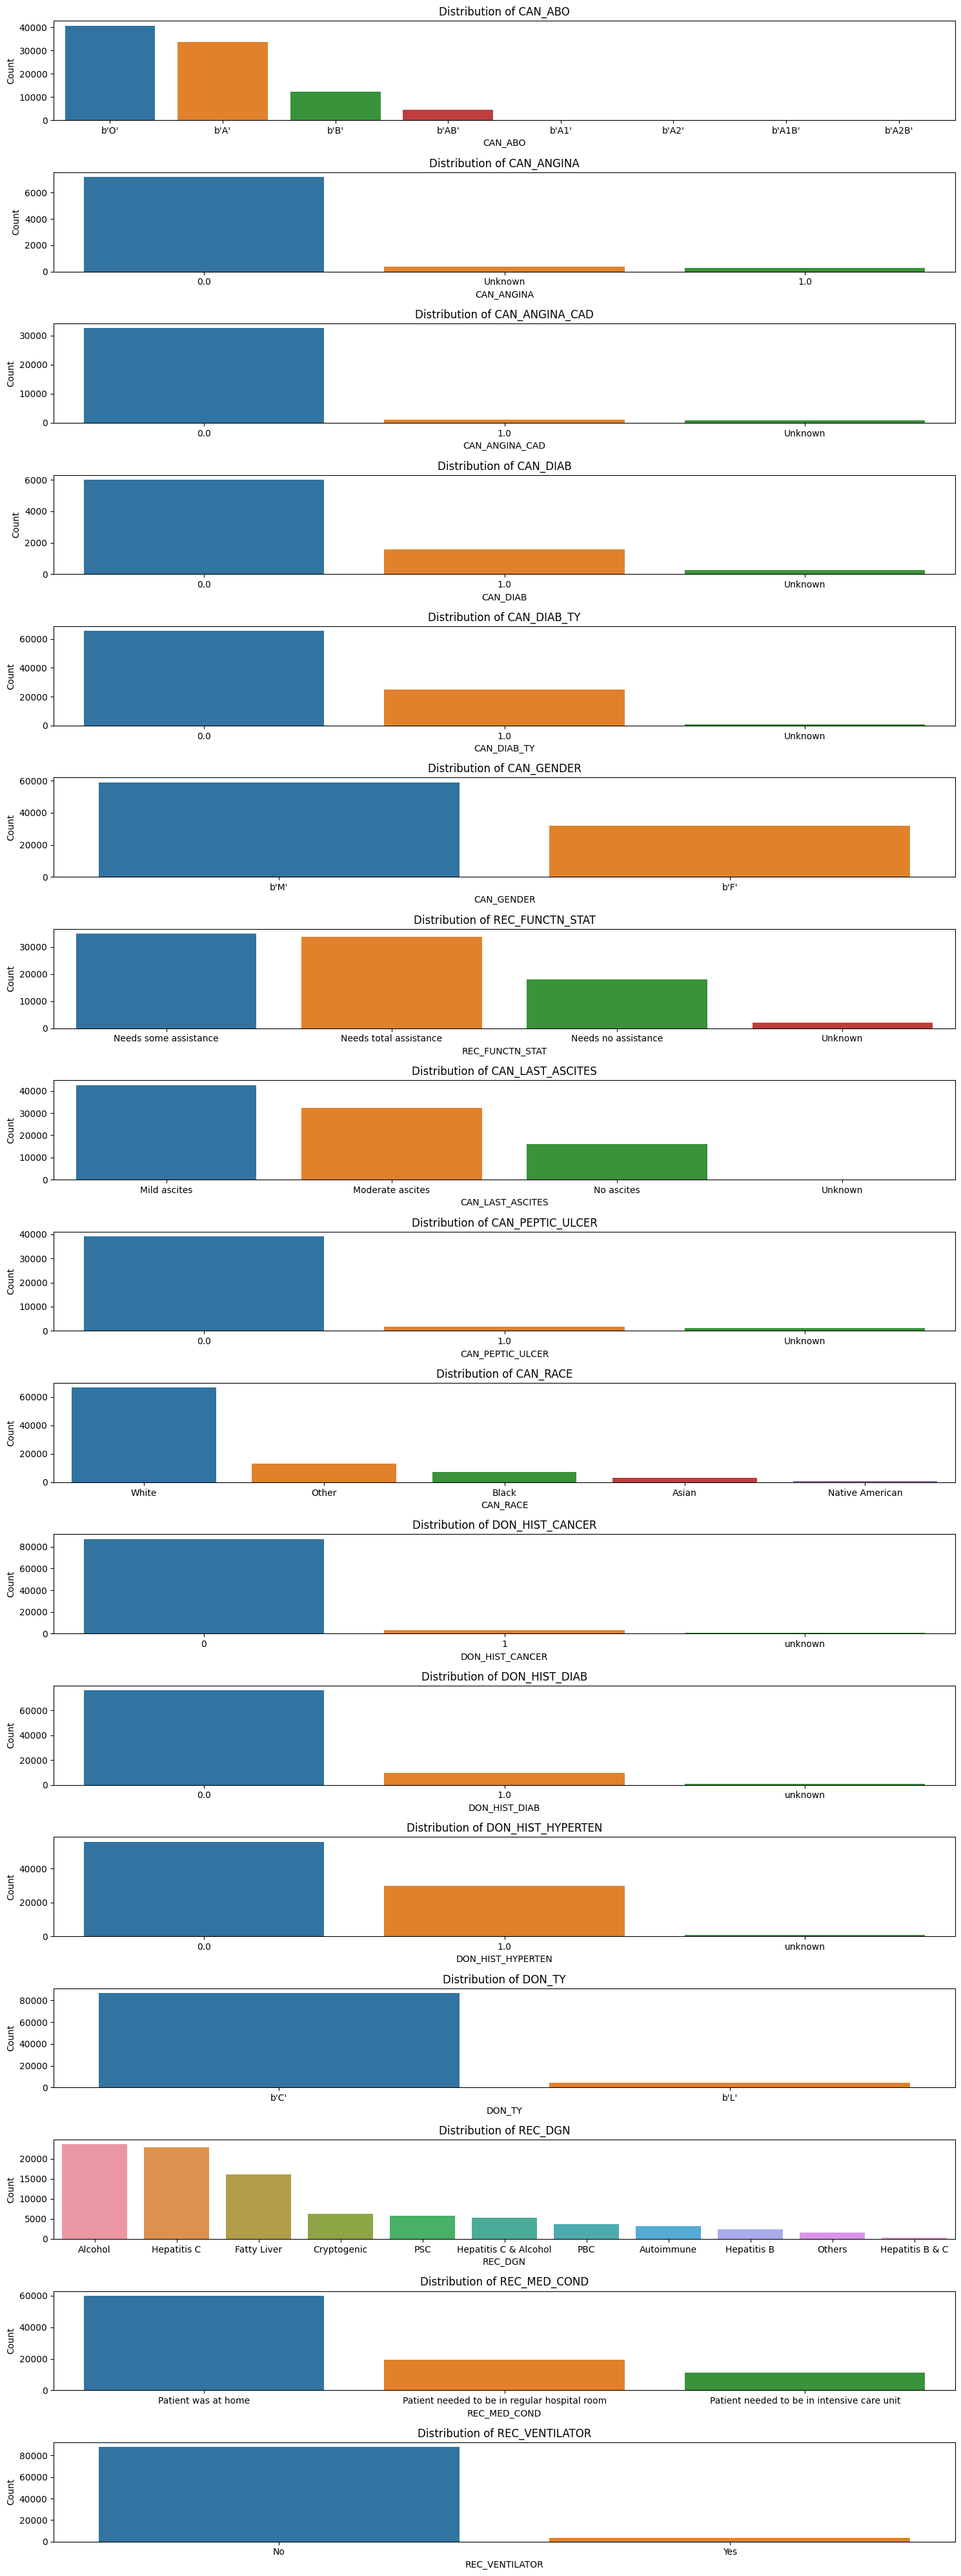

In [19]:
#exploring categorical data
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical variables to visualize
categorical_vars = [
    'CAN_ABO', 'CAN_ANGINA', 'CAN_ANGINA_CAD', 'CAN_DIAB', 'CAN_DIAB_TY', 'CAN_GENDER', 'REC_FUNCTN_STAT',
    'CAN_LAST_ASCITES', 'CAN_PEPTIC_ULCER', 'CAN_RACE', 'DON_HIST_CANCER', 'DON_HIST_DIAB',
    'DON_HIST_HYPERTEN', 'DON_TY', 'REC_DGN', 'REC_MED_COND', 'REC_VENTILATOR'
]

# Plot bar charts for each variable
plt.figure(figsize=(15, 40))
for idx, var in enumerate(categorical_vars, 1):
    plt.subplot(len(categorical_vars), 1, idx)
    sns.countplot(data=df, x=var, order=df[var].value_counts().index)
    plt.title(f'Distribution of {var}')
    plt.ylabel('Count')
    plt.xlabel(var)
    plt.tight_layout()

plt.show()


In [20]:
#exploring boolean variables

boolean_vars = [
    'CAN_BACTERIA_PERIT', 'CAN_CEREB_VASC', 'CAN_DRUG_TREAT_COPD', 'CAN_DRUG_TREAT_HYPERTEN',
    'CAN_LAST_DIAL_PRIOR_WEEK', 'REC_INOTROP_BP_SUPPORT', 'REC_MALIG', 'CAN_PERIPH_VASC',
    'CAN_PORTAL_VEIN', 'CAN_PREV_ABDOM_SURG', 'CAN_PULM_EMBOL', 'CAN_TIPSS', 'DON_MEET_CDC_HIGH_RISK',
    'REC_PORTAL_HYPERTEN_BLEED', 'REC_VARICEAL_BLEEDING'
]

# Generate frequency tables for each boolean variable
freq_tables_boolean = {}
for var in boolean_vars:
    freq_table = df[var].value_counts(normalize=True) * 100
    freq_tables_boolean[var] = freq_table

freq_tables_boolean


{'CAN_BACTERIA_PERIT': CAN_BACTERIA_PERIT
 b'N'    89.028392
 b'Y'     9.327568
 b'U'     1.644040
 Name: proportion, dtype: float64,
 'CAN_CEREB_VASC': CAN_CEREB_VASC
 b'N'    97.010199
 b'U'     2.177153
 b'Y'     0.812648
 Name: proportion, dtype: float64,
 'CAN_DRUG_TREAT_COPD': CAN_DRUG_TREAT_COPD
 b'N'    95.756049
 b'Y'     2.130214
 b'U'     2.113737
 Name: proportion, dtype: float64,
 'CAN_DRUG_TREAT_HYPERTEN': CAN_DRUG_TREAT_HYPERTEN
 b'N'    73.173305
 b'Y'    24.398134
 b'U'     2.428561
 Name: proportion, dtype: float64,
 'CAN_LAST_DIAL_PRIOR_WEEK': CAN_LAST_DIAL_PRIOR_WEEK
 b'N'    85.088711
 b'Y'    14.758775
 b'A'     0.152514
 Name: proportion, dtype: float64,
 'REC_INOTROP_BP_SUPPORT': REC_INOTROP_BP_SUPPORT
 b'N'    92.481618
 b'U'     4.062500
 b'Y'     3.455882
 Name: proportion, dtype: float64,
 'REC_MALIG': REC_MALIG
 b'N'    93.678025
 b'Y'     4.208193
 b'U'     2.113783
 Name: proportion, dtype: float64,
 'CAN_PERIPH_VASC': CAN_PERIPH_VASC
 b'N'    96.592710
 

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


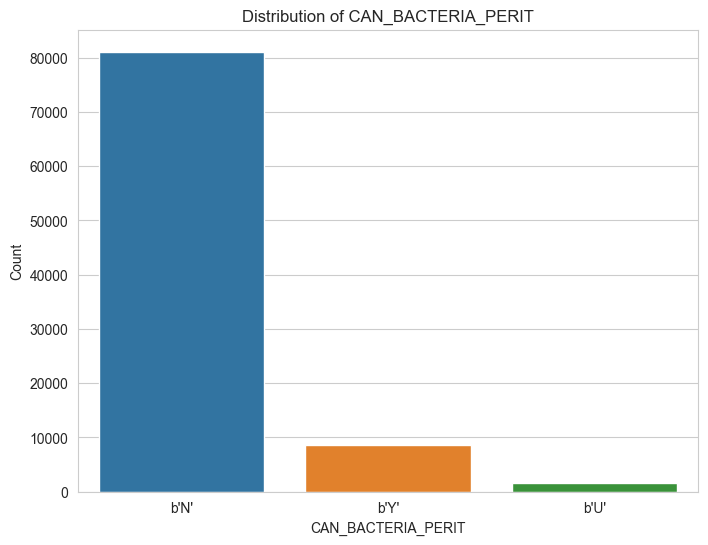

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


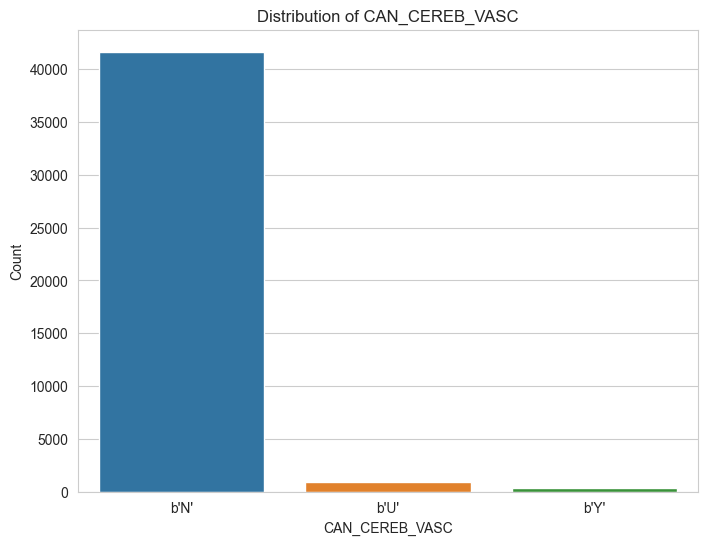

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


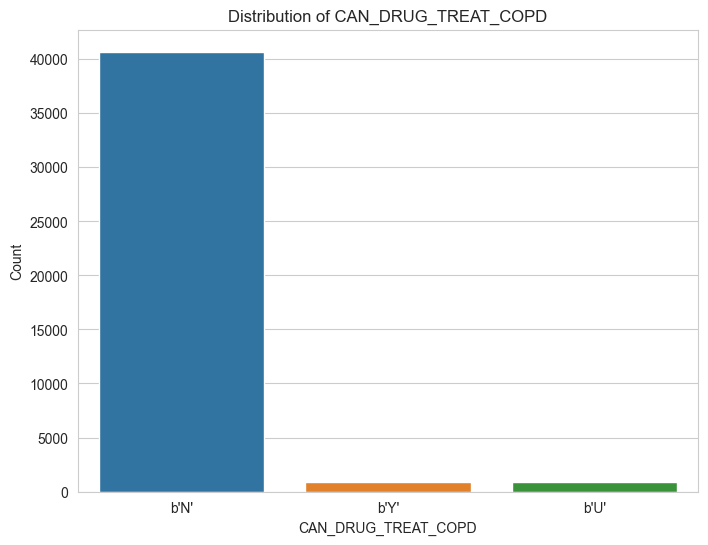

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


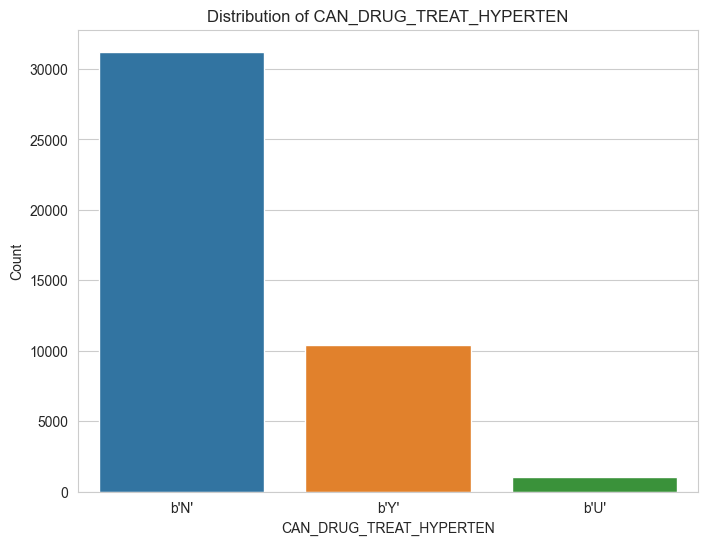

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


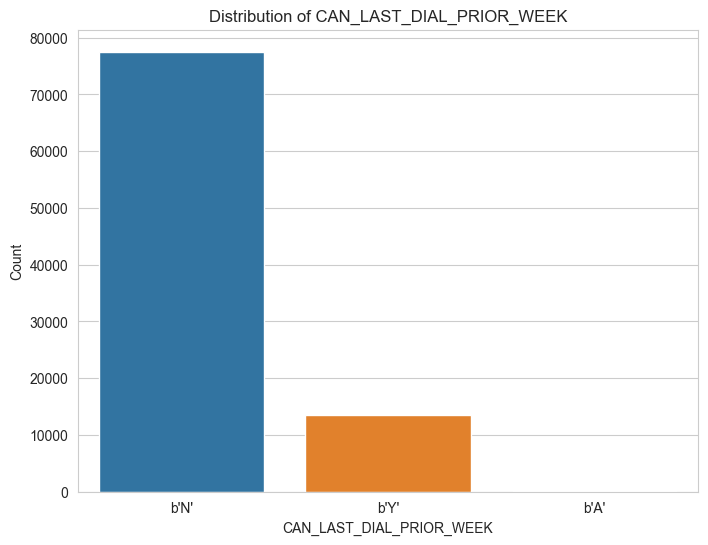

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


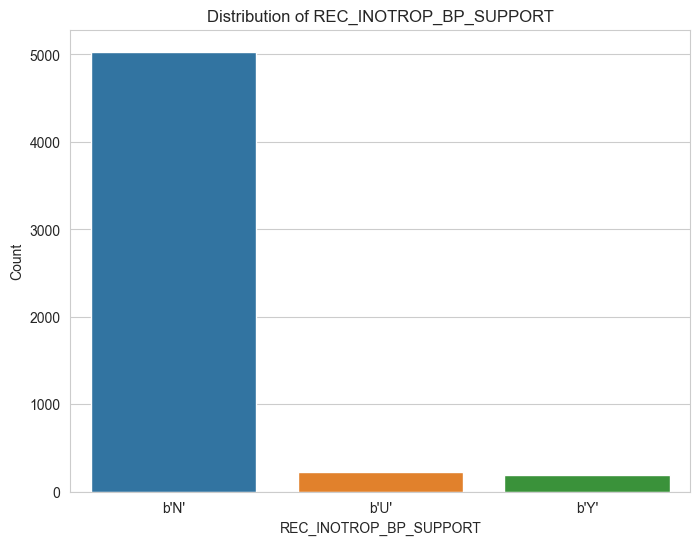

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


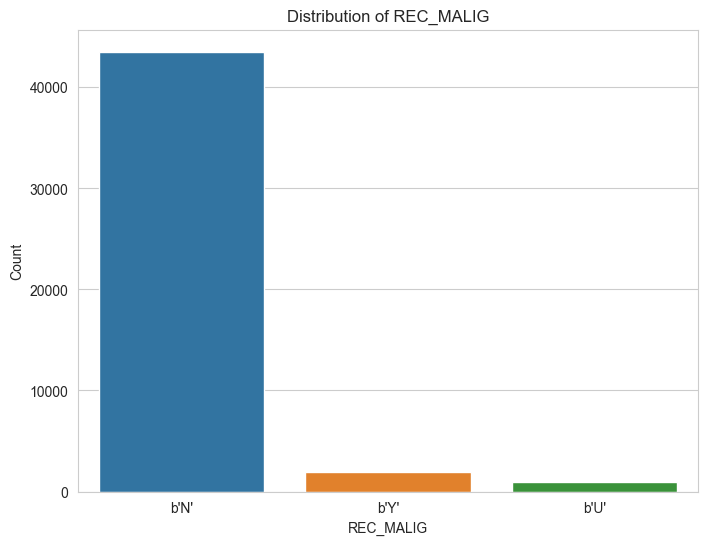

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


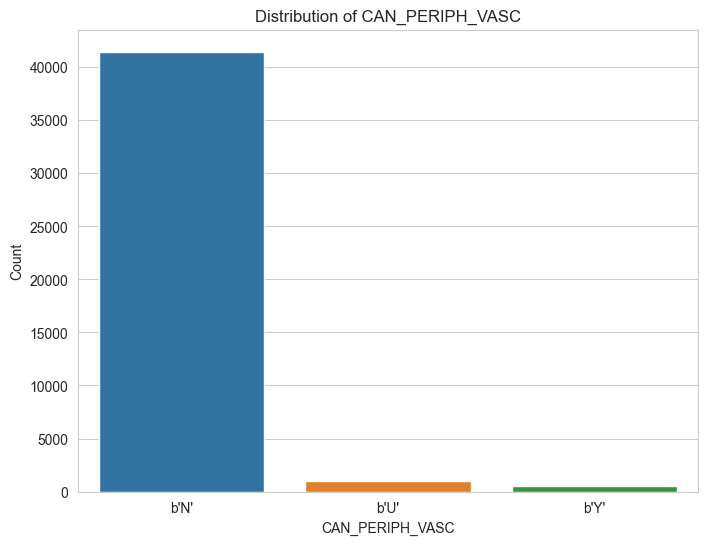

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


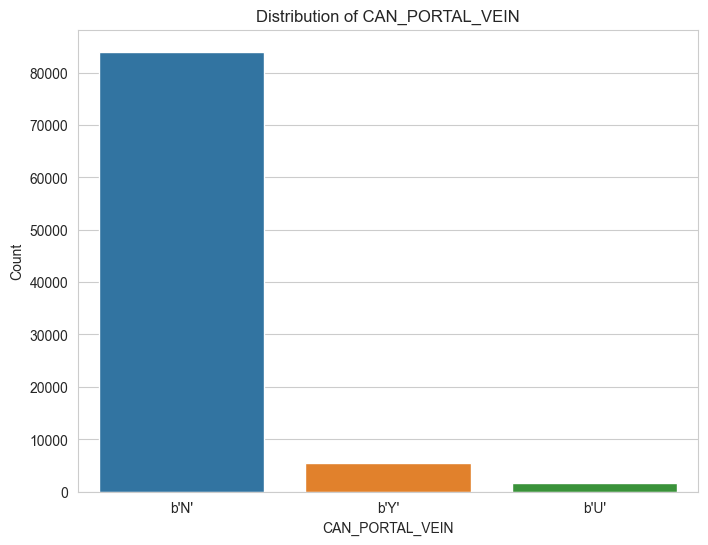

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


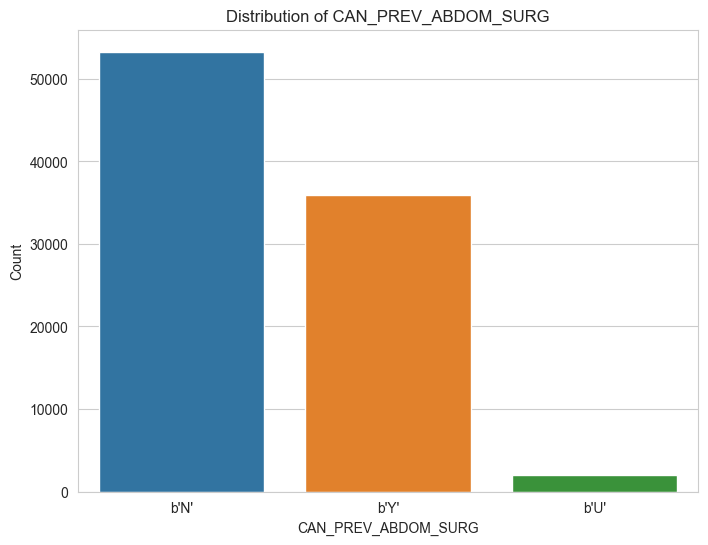

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


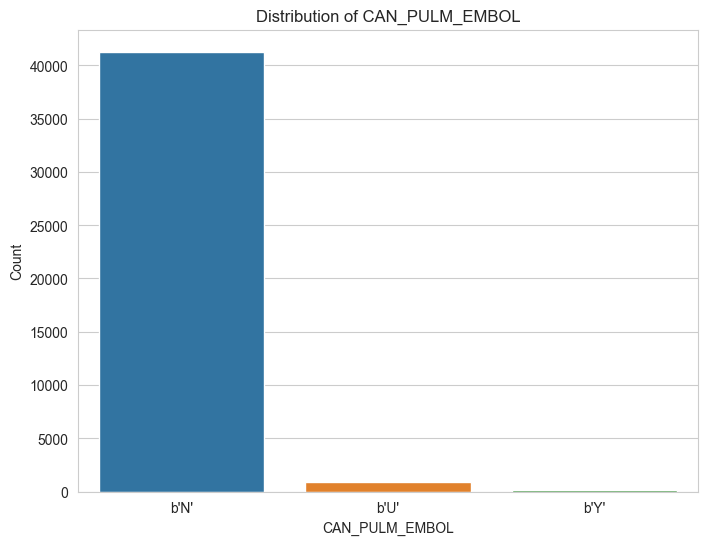

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


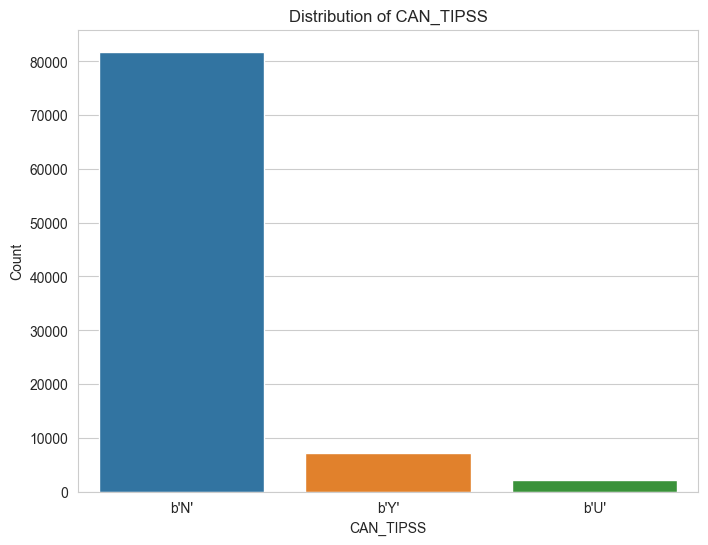

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


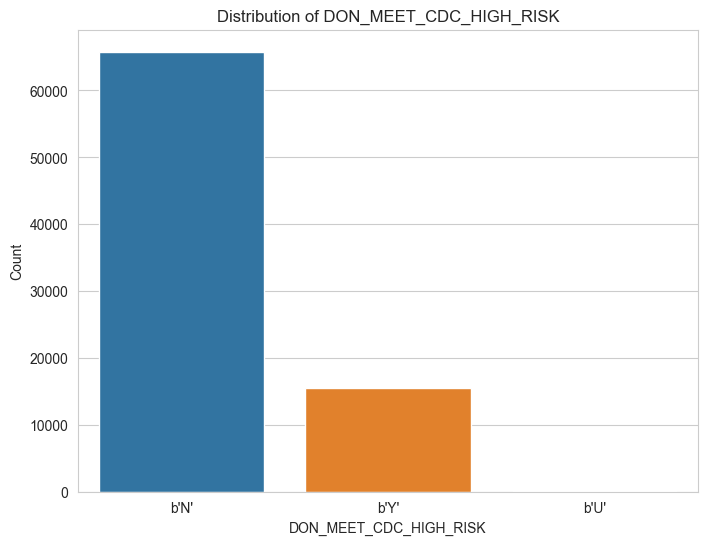

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


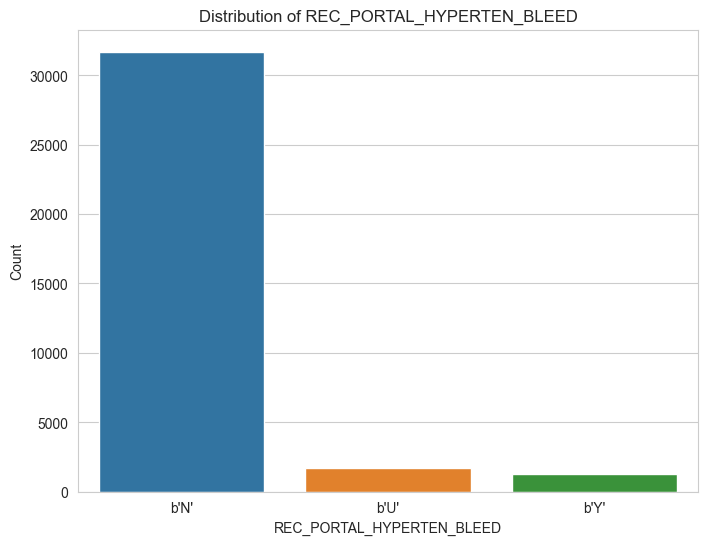

/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


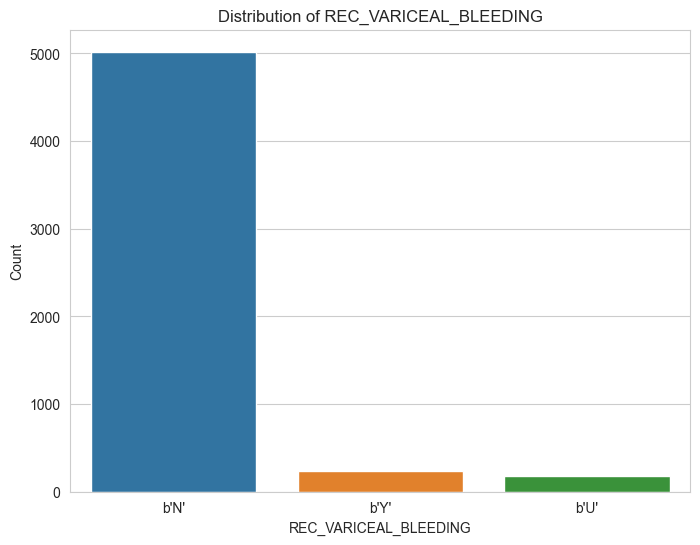

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Create histograms for each boolean variable
for var in boolean_vars:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=var, order=df[var].value_counts().index)
    plt.title(f'Distribution of {var}')
    plt.ylabel('Count')
    plt.show()


In [22]:
# List of continuous variables to explore
continuous_vars = [
    'REC_AGE_AT_TX', 'CAN_HGT_CM', 'CAN_LAST_ALBUMIN', 'CAN_LAST_BILI', 'CAN_LAST_INR',
    'CAN_LAST_SERUM_CREAT', 'CAN_LAST_SERUM_SODIUM', 'CAN_WGT_KG', 'DON_AGE_IN_MONTHS',
    'DON_WARM_ISCH_TM_MINS', 'DON_WGT_KG', 'CAN_LAST_SRTR_LAB_MELD'
]

# Generate descriptive statistics for each continuous variable
descriptive_stats = df[continuous_vars].describe()
descriptive_stats


,REC_AGE_AT_TX,CAN_HGT_CM,CAN_LAST_ALBUMIN,CAN_LAST_BILI,CAN_LAST_INR,CAN_LAST_SERUM_CREAT,CAN_LAST_SERUM_SODIUM,CAN_WGT_KG,DON_AGE_IN_MONTHS,DON_WARM_ISCH_TM_MINS,DON_WGT_KG,CAN_LAST_SRTR_LAB_MELD
count,91139.000000,90950.000000,91138.000000,91138.000000,91138.000000,91138.000000,83837.000000,91033.000000,91139.000000,23100.000000,91004.000000,91139.000000
mean,54.868783,171.908207,3.057631,8.818906,1.960494,1.620674,135.325992,86.366496,500.447624,3.835152,81.546643,22.883409
std,10.043827,10.382609,0.713779,10.762967,1.193167,1.385345,5.231485,20.292143,193.336910,8.712290,20.522946,9.485026
min,18.000000,1.600000,0.500000,0.060000,0.500000,0.000000,100.000000,2.268000,27.000000,0.000000,3.900000,6.000000
25%,49.000000,165.100000,2.600000,2.100000,1.400000,0.800000,132.000000,72.121000,336.000000,0.000000,68.000000,15.000000
50%,56.000000,172.720000,3.000000,4.300000,1.700000,1.130000,136.000000,84.368100,499.000000,0.000000,79.379000,22.000000
75%,62.000000,180.300000,3.500000,10.800000,2.290000,1.800000,139.000000,98.883000,649.000000,0.000000,92.800000,30.000000
max,81.000000,225.000000,9.900000,99.000000,99.000000,26.000000,174.000000,263.000000,1143.000000,175.000000,284.000000,40.000000


/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wil

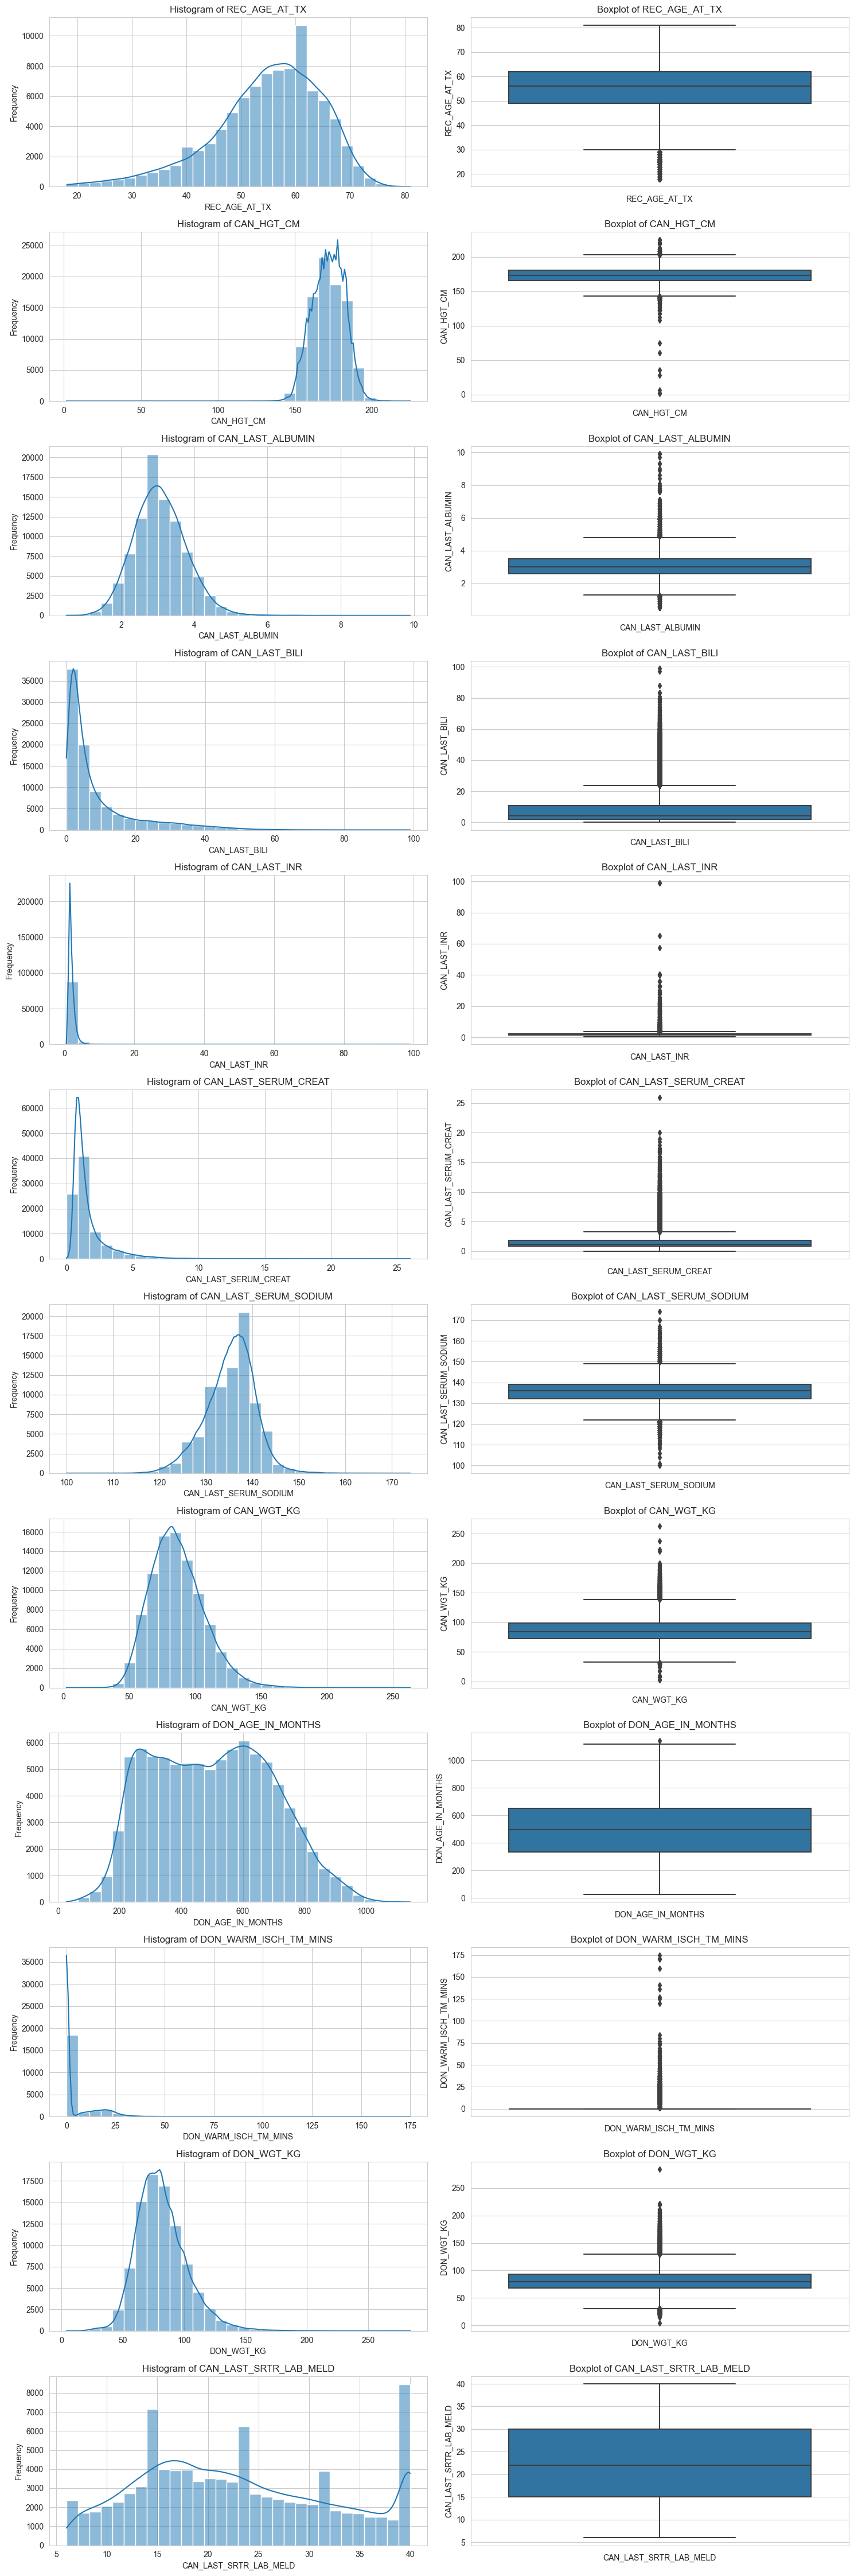

In [23]:
# Plotting histograms and boxplots for each continuous variable

plt.figure(figsize=(15, 45))

for idx, var in enumerate(continuous_vars, 1):
    # Histogram
    plt.subplot(len(continuous_vars), 2, 2*idx-1)
    sns.histplot(df[var], kde=True, bins=30)
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(len(continuous_vars), 2, 2*idx)
    sns.boxplot(y=df[var])
    plt.title(f'Boxplot of {var}')
    plt.xlabel(var)

plt.tight_layout()
plt.show()


In [24]:
# Some continous variables do not make physiological sense, they are likely mistakenly inputed. I removed them or capped them based on clinical judgement
df.loc[df['CAN_LAST_SERUM_CREAT'] < 0.3, 'CAN_LAST_SERUM_CREAT'] = 0.3
df.loc[df['CAN_HGT_CM'] < 100, 'CAN_HGT_CM'] = None
df.loc[df['CAN_WGT_KG'] < 40, 'CAN_WGT_KG'] = None
df.loc[df['DON_WGT_KG'] < 40, 'DON_WGT_KG'] = None
df.loc[df['DON_AGE_IN_MONTHS'] < 100, 'DON_AGE_IN_MONTHS'] = None
df.loc[df['CAN_LAST_INR'] > 20, 'CAN_LAST_INR'] = 20
df.loc[df['CAN_LAST_ALBUMIN'] > 7, 'CAN_LAST_ALBUMIN'] = 7

count    91139.000000
mean      2046.427029
std       1801.626218
min          0.000000
25%        486.000000
50%       1514.000000
75%       3209.000000
max       7680.000000
Name: TX_SURV, dtype: float64


/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yumcoder/anaconda3/envs/llm-knn/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

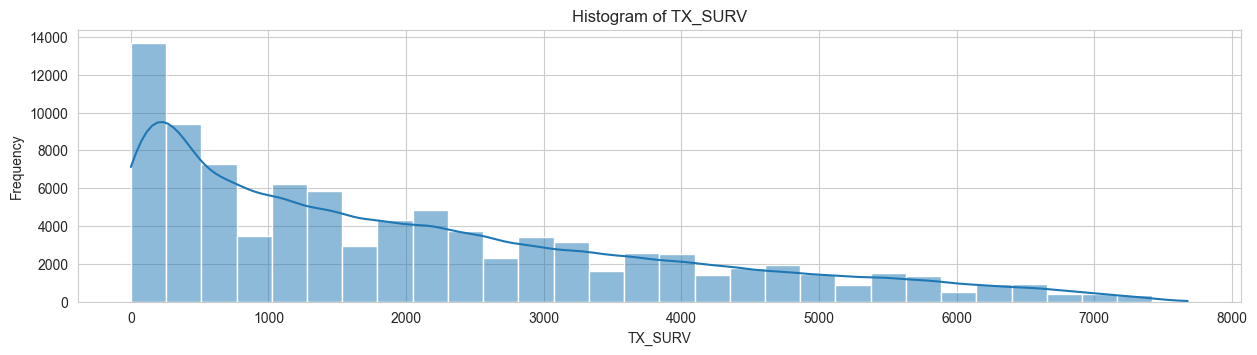

In [25]:
#Post transplant survival description, which is our outcome
# Generate descriptive statistics for the TX_SURV variable
descriptive_stats_TX_SURV = df['TX_SURV'].describe()
print(descriptive_stats_TX_SURV)

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting histogram, boxplot, and density plot for TX_SURV

plt.figure(figsize=(15, 12))

# Histogram
plt.subplot(3, 1, 1)
sns.histplot(df['TX_SURV'], kde=True, bins=30)
plt.title('Histogram of TX_SURV')
plt.xlabel('TX_SURV')
plt.ylabel('Frequency')


In [26]:
#how many patietns died within 1, 3 and 5 years after liver transplantation: this will be our outcome
count_365 = (df['TX_SURV'] < 365).sum()
count_1095 = (df['TX_SURV'] < 1095).sum()
count_1836 = (df['TX_SURV'] < 1836).sum()

print("Number of patients with TX_SURV < 365:", count_365)
print("Number of patients with TX_SURV < 1095:", count_1095)
print("Number of patients with TX_SURV < 1836:", count_1836)

Number of patients with TX_SURV < 365: 18119
Number of patients with TX_SURV < 1095: 36597
Number of patients with TX_SURV < 1836: 50726


In [27]:
# Describing the causes of death
# Generate frequency and percentage for the TFL_COD categorical variable
category_counts = df['TFL_COD'].value_counts()
category_percentage = df['TFL_COD'].value_counts(normalize=True) * 100

# Combine counts and percentages into one dataframe for a better view
descriptive_stats_TFL_COD = pd.DataFrame({
    'Counts': category_counts,
    'Percentage (%)': category_percentage
})

print(descriptive_stats_TFL_COD)


                     Counts  Percentage (%)
TFL_COD                                    
Unknown                5581       21.891425
Malignancy             3310       12.983447
Infection              3064       12.018514
Cardiovascular         3017       11.834157
Other                  2936       11.516435
Graft failure          2088        8.190162
MOF                    1983        7.778301
Respiratory failure    1394        5.467953
Cerebrovascular         774        3.036008
Renal failure           526        2.063231
Bleeding                376        1.474857
Trauma                  172        0.674669
GI bleeding             103        0.404017
PE                       91        0.356947
Suicide                  79        0.309877


In [28]:
df[df['CAN_ANGINA'].notnull() ]['CAN_ANGINA']

210       0.0
819       0.0
1199      0.0
4178      0.0
4982      0.0
         ... 
135089    0.0
135226    0.0
135315    0.0
135366    0.0
135485    0.0
Name: CAN_ANGINA, Length: 7866, dtype: object

In [29]:
import numpy as np # linear algebra

In [30]:
df['CAN_ANGINA'] = df['CAN_ANGINA'].apply(lambda x: int(x) if x in [0.0, 1.0] else np.nan)
df['CAN_ANGINA'].unique()

array([nan,  0.,  1.])

In [31]:
df['CAN_ANGINA_CAD'] = df['CAN_ANGINA_CAD'].apply(lambda x: int(x) if x in [0.0, 1.0] else np.nan)
df['CAN_ANGINA_CAD'].unique()

array([ 0., nan,  1.])

In [32]:
df['CAN_DIAB'] = df['CAN_DIAB'].apply(lambda x: int(x) if x in [0.0, 1.0] else np.nan)
df['CAN_DIAB'].unique()

array([nan,  0.,  1.])

In [33]:
df['CAN_DIAB_TY'] = df['CAN_DIAB_TY'].apply(lambda x: int(x) if x in [0.0, 1.0] else np.nan)
df['CAN_DIAB_TY'].unique()

array([ 0.,  1., nan])

In [34]:
df['CAN_PEPTIC_ULCER'] = df['CAN_PEPTIC_ULCER'].apply(lambda x: int(x) if x in [0.0, 1.0] else np.nan)
df['DON_HIST_CANCER'] = df['DON_HIST_CANCER'].apply(lambda x: int(x) if x in [0.0, 1.0] else np.nan)
df['DON_HIST_DIAB'] = df['DON_HIST_DIAB'].apply(lambda x: int(x) if x in [0.0, 1.0] else np.nan)
df['CAN_PEPTIC_ULCER'].unique()
df['DON_HIST_CANCER'].unique()
df['DON_HIST_DIAB'].unique()

array([ 0.,  1., nan])

In [35]:
df['DON_HIST_HYPERTEN'] = df['DON_HIST_HYPERTEN'].apply(lambda x: int(x) if x in [0.0, 1.0] else np.nan)
df['DON_HIST_HYPERTEN'].unique()

array([ 0.,  1., nan])

In [36]:
df['DON_HIST_HYPERTEN'].unique()

array([ 0.,  1., nan])

In [37]:

df['REC_FUNCTN_STAT'].fillna('Unknown', inplace=True)
df['REC_FUNCTN_STAT'].unique()

array(['Needs some assistance', 'Needs total assistance',
       'Needs no assistance', 'Unknown'], dtype=object)

In [38]:
df['CAN_LAST_ASCITES'].fillna('Unknown', inplace=True)
df['CAN_LAST_ASCITES'].unique()

array(['Mild ascites', 'Moderate ascites', 'No ascites', 'Unknown'],
      dtype=object)

In [39]:
df['TFL_LASTATUS']

1         b'A'
4         b'D'
5         b'A'
6         b'A'
7         b'A'
          ... 
136533    b'D'
136534    b'A'
136538    b'A'
136539    b'A'
136540    b'A'
Name: TFL_LASTATUS, Length: 91139, dtype: object

In [87]:
cat_onehot_cols = [
    #these are boolean
    'CAN_BACTERIA_PERIT', 'CAN_CEREB_VASC', 'CAN_DRUG_TREAT_COPD', 'CAN_DRUG_TREAT_HYPERTEN',
    'CAN_LAST_DIAL_PRIOR_WEEK', 'REC_INOTROP_BP_SUPPORT', 'REC_MALIG', 'CAN_PERIPH_VASC',
    'CAN_PORTAL_VEIN', 'CAN_PREV_ABDOM_SURG', 'CAN_PULM_EMBOL', 'CAN_TIPSS', 'DON_MEET_CDC_HIGH_RISK',
    'REC_PORTAL_HYPERTEN_BLEED', 'REC_VARICEAL_BLEEDING',
     #these are categorical
    'CAN_ABO', 'CAN_ANGINA', 'CAN_ANGINA_CAD', 'CAN_DIAB', 'CAN_DIAB_TY', 'CAN_GENDER',
    'CAN_PEPTIC_ULCER', 'CAN_RACE', 'DON_HIST_CANCER', 'DON_HIST_DIAB',
    'DON_HIST_HYPERTEN', 'DON_TY', 'REC_DGN', 'REC_MED_COND', 'REC_VENTILATOR', 'TFL_COD'
    ]

#these are continous
continuous_cols = ['REC_AGE_AT_TX', 'CAN_HGT_CM', 'CAN_LAST_ALBUMIN', 'CAN_LAST_BILI', 'CAN_LAST_INR',
    'CAN_LAST_SERUM_CREAT', 'CAN_LAST_SERUM_SODIUM', 'CAN_WGT_KG', 'DON_AGE_IN_MONTHS',
    'DON_WARM_ISCH_TM_MINS', 'DON_WGT_KG', 'CAN_LAST_SRTR_LAB_MELD']

# these 2 are better defined as ordinal:
cat_ordinal_cols = [ 'REC_FUNCTN_STAT', 'CAN_LAST_ASCITES']

In [88]:
# import pandas as pd # dataframe manipulation
# from sentence_transformers import SentenceTransformer
# from transformers import AutoModel
# # Check if the model exists, and if not, download it
# model_name = "sentence-transformers/paraphrase-MiniLM-L6-v2"
# try:
#     model = SentenceTransformer(model_name)
# except Exception as e:
#     print(f"Model '{model_name}' not found. Downloading it...")
#     AutoModel.from_pretrained(model_name)
#     model = SentenceTransformer(model_name)
#     print(f"Model '{model_name}' downloaded and loaded successfully.")

# def compile_text(row):
#     text = ""
    
#     for col in cat_onehot_cols + continuous_cols + cat_ordinal_cols:
#         value = row[col]
#         if pd.notnull(value):
#             text += f"{col}: {value},"

#     return text.strip()

# # Apply the function to your dataset
# sentences = df.apply(compile_text, axis=1).tolist()

# # Encode the sentences
# output = model.encode(sentences=sentences, show_progress_bar=True, normalize_embeddings=True)


# new_column1 = df['TFL_LASTATUS'].apply(lambda x: 1 if x == "b'D'" else 0)
# new_column2 = df['TX_SURV']

# # Convert the pandas Series to NumPy arrays
# new_column1_array = new_column1.to_numpy().reshape(-1, 1)
# new_column2_array = new_column2.to_numpy().reshape(-1, 1)

# result_array = np.hstack((output, new_column1_array, new_column2_array))

# result_array




In [89]:
# # Create a DataFrame from the embeddings
# df_embedding = pd.DataFrame(result_array)

# # Save the DataFrame to a CSV file
# df_embedding.to_csv("./data/embedding_tx_li_rq_1.csv", index=False)

In [2]:
import pandas as pd
result_array = pd.read_csv("data/embedding_tx_li_rq_1.csv", sep = ",")
result_array

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,384,385
0,-0.010729,0.063767,-0.071078,-0.073549,-0.069263,-0.027596,0.034974,-0.010132,0.031699,-0.037212,...,0.029584,-0.054657,-0.006890,0.027820,0.037880,-0.080625,-0.035807,0.035906,0.0,3659.0
1,-0.011036,0.063000,-0.069259,-0.072524,-0.068626,-0.029029,0.034394,-0.010344,0.030801,-0.037396,...,0.028995,-0.055832,-0.007542,0.028545,0.038008,-0.080233,-0.036149,0.035374,1.0,2398.0
2,-0.011036,0.063000,-0.069259,-0.072524,-0.068626,-0.029029,0.034394,-0.010344,0.030801,-0.037396,...,0.028995,-0.055832,-0.007542,0.028545,0.038008,-0.080233,-0.036149,0.035374,0.0,3618.0
3,-0.011036,0.063000,-0.069259,-0.072524,-0.068626,-0.029029,0.034394,-0.010344,0.030801,-0.037396,...,0.028995,-0.055832,-0.007542,0.028545,0.038008,-0.080233,-0.036149,0.035374,0.0,3518.0
4,-0.008875,0.065497,-0.071157,-0.074555,-0.065568,-0.034149,0.036791,-0.011090,0.031122,-0.034495,...,0.032091,-0.053136,-0.006812,0.025268,0.035087,-0.074550,-0.036101,0.031534,0.0,3630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91134,-0.008610,0.066971,-0.070901,-0.074972,-0.062783,-0.036831,0.037312,-0.010860,0.030800,-0.032683,...,0.032829,-0.053363,-0.007523,0.023738,0.034608,-0.071656,-0.034034,0.029874,1.0,21.0
91135,0.021902,0.069531,-0.068175,-0.072337,-0.039113,-0.001825,0.038039,0.003886,0.009298,-0.027075,...,0.045000,-0.018788,0.019192,0.009732,0.048381,-0.057766,-0.072442,0.000692,0.0,3536.0
91136,-0.011311,0.062187,-0.070457,-0.071079,-0.071860,-0.024291,0.034570,-0.009793,0.032192,-0.038009,...,0.027825,-0.056099,-0.008162,0.030121,0.039901,-0.084124,-0.037138,0.038673,0.0,3440.0
91137,-0.011311,0.062187,-0.070457,-0.071079,-0.071860,-0.024291,0.034570,-0.009793,0.032192,-0.038009,...,0.027825,-0.056099,-0.008162,0.030121,0.039901,-0.084124,-0.037138,0.038673,0.0,3737.0


In [97]:
# result_df = pd.DataFrame(result_array[:, :-2])
# result_df.shape
# result_array.shape
result_df = result_array.iloc[:, :-2]

#### Create ML pipeline

In [98]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt


data = result_df.copy()
# Mapping 'TFL_LASTATUS' to 'event_column' (1 for DEAD, 0 for LIVING)
data['event_column'] = df['TFL_LASTATUS'].apply(lambda x: 1 if x == "b'D'" else 0)

# Creating 'time_column'
data['time_column'] = df['TX_SURV']

filtered_data = data[data['time_column'].notnull()]


In [99]:
filtered_data

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,event_column,time_column
1,-0.011036,0.063000,-0.069259,-0.072524,-0.068626,-0.029029,0.034394,-0.010344,0.030801,-0.037396,...,0.028995,-0.055832,-0.007542,0.028545,0.038008,-0.080233,-0.036149,0.035374,0.0,3659.0
4,-0.008875,0.065497,-0.071157,-0.074555,-0.065568,-0.034149,0.036791,-0.011090,0.031122,-0.034495,...,0.032091,-0.053136,-0.006812,0.025268,0.035087,-0.074550,-0.036101,0.031534,1.0,2398.0
5,-0.010031,0.065841,-0.072421,-0.074412,-0.065910,-0.032787,0.037201,-0.009499,0.031950,-0.034038,...,0.031632,-0.054126,-0.006675,0.025166,0.035953,-0.076105,-0.034514,0.033100,0.0,3618.0
6,0.025442,0.076312,-0.063937,-0.072802,-0.047949,-0.012285,0.035675,0.006278,0.007525,-0.024514,...,0.052014,-0.021631,0.017726,0.015006,0.045532,-0.055239,-0.069483,-0.002311,0.0,3518.0
7,-0.009889,0.064591,-0.068314,-0.073496,-0.064340,-0.032747,0.034656,-0.010537,0.030511,-0.035305,...,0.030309,-0.055603,-0.008375,0.027551,0.036930,-0.077352,-0.034378,0.033997,0.0,3630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91134,-0.008610,0.066971,-0.070901,-0.074972,-0.062783,-0.036831,0.037312,-0.010860,0.030800,-0.032683,...,0.032829,-0.053363,-0.007523,0.023738,0.034608,-0.071656,-0.034034,0.029874,0.0,6940.0
91135,0.021902,0.069531,-0.068175,-0.072337,-0.039113,-0.001825,0.038039,0.003886,0.009298,-0.027075,...,0.045000,-0.018788,0.019192,0.009732,0.048381,-0.057766,-0.072442,0.000692,1.0,153.0
91136,-0.011311,0.062187,-0.070457,-0.071079,-0.071860,-0.024291,0.034570,-0.009793,0.032192,-0.038009,...,0.027825,-0.056099,-0.008162,0.030121,0.039901,-0.084124,-0.037138,0.038673,1.0,4063.0
91137,-0.011311,0.062187,-0.070457,-0.071079,-0.071860,-0.024291,0.034570,-0.009793,0.032192,-0.038009,...,0.027825,-0.056099,-0.008162,0.030121,0.039901,-0.084124,-0.037138,0.038673,0.0,429.0


In [100]:
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

# 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data.drop(['event_column', 'time_column'], axis=1),
                                                    filtered_data[['event_column', 'time_column']],
                                                    test_size=0.2, random_state=42)

# Convert 'event_column' to boolean type
y_train['event_column'] = y_train['event_column'].astype(bool)
y_test['event_column'] = y_test['event_column'].astype(bool)

# Convert data
y_train_surv = Surv.from_arrays(y_train['event_column'], y_train['time_column'])

#Train Cox Proportional Hazards Model
coxph = CoxPHSurvivalAnalysis()
coxph.fit(X_train, y_train_surv)

# Evaluate Model
result = concordance_index_censored(y_test['event_column'], y_test['time_column'], coxph.predict(X_test))
print(f"Concordance Index: {result[0]:.3f}")


Concordance Index: 0.499


In [101]:
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data.drop(['event_column', 'time_column'], axis=1),
                                                    filtered_data[['event_column', 'time_column']],
                                                    test_size=0.2, random_state=42)

# Convert 'event_column' to boolean type
y_train['event_column'] = y_train['event_column'].astype(bool)
y_test['event_column'] = y_test['event_column'].astype(bool)

# Feature Engineering
poly_pipe = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), SelectKBest(f_regression, k=10))
X_train_poly = poly_pipe.fit_transform(X_train, y_train['event_column'])
X_test_poly = poly_pipe.transform(X_test)

# Convert data
y_train_surv = Surv.from_arrays(y_train['event_column'], y_train['time_column'])

# Train Cox Proportional Hazards Model
coxph = CoxPHSurvivalAnalysis()
coxph.fit(X_train_poly, y_train_surv)

# Evaluate Model
result = concordance_index_censored(y_test['event_column'], y_test['time_column'], coxph.predict(X_test_poly))
print(f"Concordance Index: {result[0]:.3f}")


Concordance Index: 0.518


In [104]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Assuming 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times
# 'filtered_data' is your original DataFrame

# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data.drop(['event_column', 'time_column'], axis=1),
                                                    filtered_data[['event_column', 'time_column']],
                                                    test_size=0.2, random_state=42)

# Convert 'event_column' to boolean type
y_train['event_column'] = y_train['event_column'].astype(bool)
y_test['event_column'] = y_test['event_column'].astype(bool)

# Step 2: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Build the DeepSurv model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer with linear activation for survival analysis
])

model.compile(optimizer='adam', loss='mean_squared_error')  # Using mean squared error as a loss for survival analysis

# Step 4: Train the model
model.fit(X_train_scaled, y_train['time_column'].values, epochs=50, batch_size=32, validation_split=0.2)

# Step 5: Evaluate the model
predicted_times = model.predict(X_test_scaled).flatten()

# Concordance Index
result = concordance_index_censored(y_test['event_column'], y_test['time_column'], predicted_times)
print(f"Concordance Index: {result[0]:.3f}")


Epoch 1/50
1246/1246 [==============================] - 2s 817us/step - loss: 3770954.5000 - val_loss: 3102551.7500
Epoch 2/50
1246/1246 [==============================] - 1s 709us/step - loss: 3375919.5000 - val_loss: 3093916.0000
Epoch 3/50
1246/1246 [==============================] - 1s 690us/step - loss: 3357944.0000 - val_loss: 3099404.7500
Epoch 4/50
1246/1246 [==============================] - 1s 696us/step - loss: 3365074.2500 - val_loss: 3096617.2500
Epoch 5/50
1246/1246 [==============================] - 1s 712us/step - loss: 3358653.5000 - val_loss: 3094492.0000
Epoch 6/50
1246/1246 [==============================] - 1s 720us/step - loss: 3342271.7500 - val_loss: 3088559.5000
Epoch 7/50
1246/1246 [==============================] - 1s 709us/step - loss: 3339546.7500 - val_loss: 3101443.5000
Epoch 8/50
1246/1246 [==============================] - 1s 794us/step - loss: 3350868.0000 - val_loss: 3116373.0000
Epoch 9/50
1246/1246 [==============================] - 1s 743us/step - 

In [110]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

# Assuming 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times
# 'filtered_data' is your original DataFrame

# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data.drop(['event_column', 'time_column'], axis=1),
                                                    filtered_data[['event_column', 'time_column']],
                                                    test_size=0.2, random_state=42)

# Convert 'event_column' to boolean type
y_train['event_column'] = y_train['event_column'].astype(bool)
y_test['event_column'] = y_test['event_column'].astype(bool)

# Step 2: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Build the DeepSurv model
model = tf.keras.Sequential([
   Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='linear')  # Output layer with linear activation for survival analysis
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Adjust the learning rate

model.compile(optimizer=optimizer, loss='mean_squared_error')  # Using mean squared error as a loss for survival analysis

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 4: Train the model
history = model.fit(X_train_scaled, y_train['time_column'].values, epochs=100, batch_size=128,
                    validation_split=0.2, callbacks=[early_stopping])

# Step 5: Evaluate the model
predicted_times = model.predict(X_test_scaled).flatten()

# Concordance Index
result = concordance_index_censored(y_test['event_column'], y_test['time_column'], predicted_times)
print(f"Concordance Index: {result[0]:.3f}")


Epoch 1/100
312/312 [==============================] - 4s 8ms/step - loss: 9606764.0000 - val_loss: 9557167.0000
Epoch 2/100
312/312 [==============================] - 2s 8ms/step - loss: 9601166.0000 - val_loss: 9551242.0000
Epoch 3/100
312/312 [==============================] - 2s 8ms/step - loss: 9591209.0000 - val_loss: 9539430.0000
Epoch 4/100
312/312 [==============================] - 2s 7ms/step - loss: 9577061.0000 - val_loss: 9525014.0000
Epoch 5/100
312/312 [==============================] - 2s 7ms/step - loss: 9558792.0000 - val_loss: 9505401.0000
Epoch 6/100
312/312 [==============================] - 2s 8ms/step - loss: 9536254.0000 - val_loss: 9482610.0000
Epoch 7/100
312/312 [==============================] - 2s 7ms/step - loss: 9510039.0000 - val_loss: 9457583.0000
Epoch 8/100
312/312 [==============================] - 2s 7ms/step - loss: 9481835.0000 - val_loss: 9421806.0000
Epoch 9/100
312/312 [==============================] - 2s 7ms/step - loss: 9449502.0000 - val_lo

In [117]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

# Assuming 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times
# 'filtered_data' is your original DataFrame

# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data.drop(['event_column', 'time_column'], axis=1),
                                                    filtered_data[['event_column', 'time_column']],
                                                    test_size=0.2, random_state=42)

# Convert 'event_column' to boolean type
y_train['event_column'] = y_train['event_column'].astype(bool)
y_test['event_column'] = y_test['event_column'].astype(bool)

# Step 2: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Build the DeepSurv model
model = tf.keras.Sequential([
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='linear')  # Output layer with linear activation for survival analysis
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Adjust the learning rate

model.compile(optimizer=optimizer, loss='mean_squared_error')  # Using mean squared error as a loss for survival analysis

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 4: Train the model
history = model.fit(X_train_scaled, y_train['time_column'].values, epochs=100, batch_size=64,
                    validation_split=0.2, callbacks=[early_stopping])

# Step 5: Evaluate the model
predicted_times = model.predict(X_test_scaled).flatten()

# Concordance Index
result = concordance_index_censored(y_test['event_column'], y_test['time_column'], predicted_times)
print(f"Concordance Index: {result[0]:.3f}")


Epoch 1/100
623/623 [==============================] - 5s 6ms/step - loss: 9608035.0000 - val_loss: 9559131.0000
Epoch 2/100
623/623 [==============================] - 4s 6ms/step - loss: 9606156.0000 - val_loss: 9556540.0000
Epoch 3/100
623/623 [==============================] - 4s 6ms/step - loss: 9604185.0000 - val_loss: 9553559.0000
Epoch 4/100
623/623 [==============================] - 3s 5ms/step - loss: 9601976.0000 - val_loss: 9551240.0000
Epoch 5/100
623/623 [==============================] - 4s 6ms/step - loss: 9599069.0000 - val_loss: 9547910.0000
Epoch 6/100
623/623 [==============================] - 4s 6ms/step - loss: 9595880.0000 - val_loss: 9545432.0000
Epoch 7/100
623/623 [==============================] - 4s 6ms/step - loss: 9592119.0000 - val_loss: 9540176.0000
Epoch 8/100
623/623 [==============================] - 4s 6ms/step - loss: 9587856.0000 - val_loss: 9536032.0000
Epoch 9/100
623/623 [==============================] - 4s 6ms/step - loss: 9583287.0000 - val_lo

In [123]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

# Assuming 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times
# 'filtered_data' is your original DataFrame

# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data.drop(['event_column', 'time_column'], axis=1),
                                                    filtered_data[['event_column', 'time_column']],
                                                    test_size=0.2, random_state=42)

# Convert 'event_column' to boolean type
y_train['event_column'] = y_train['event_column'].astype(bool)
y_test['event_column'] = y_test['event_column'].astype(bool)

# Step 2: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Build the DeepSurv model
model = tf.keras.Sequential([
    Dense(384, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='linear')  # Output layer with linear activation for survival analysis
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Adjust the learning rate

model.compile(optimizer=optimizer, loss='mean_squared_error')  # Using mean squared error as a loss for survival analysis

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 4: Train the model
history = model.fit(X_train_scaled, y_train['time_column'].values, epochs=200, batch_size=64,
                    validation_split=0.2, callbacks=[early_stopping])

# Step 5: Evaluate the model
predicted_times = model.predict(X_test_scaled).flatten()

# Concordance Index
result = concordance_index_censored(y_test['event_column'], y_test['time_column'], predicted_times)
print(f"Concordance Index: {result[0]:.3f}")


Epoch 1/200
623/623 [==============================] - 2s 3ms/step - loss: 9606754.0000 - val_loss: 9557044.0000
Epoch 2/200
623/623 [==============================] - 2s 3ms/step - loss: 9602917.0000 - val_loss: 9554448.0000
Epoch 3/200
623/623 [==============================] - 2s 3ms/step - loss: 9597854.0000 - val_loss: 9548344.0000
Epoch 4/200
623/623 [==============================] - 2s 3ms/step - loss: 9591010.0000 - val_loss: 9539802.0000
Epoch 5/200
623/623 [==============================] - 2s 3ms/step - loss: 9582021.0000 - val_loss: 9532963.0000
Epoch 6/200
623/623 [==============================] - 2s 3ms/step - loss: 9571250.0000 - val_loss: 9520699.0000
Epoch 7/200
623/623 [==============================] - 2s 3ms/step - loss: 9558697.0000 - val_loss: 9509269.0000
Epoch 8/200
623/623 [==============================] - 2s 3ms/step - loss: 9544504.0000 - val_loss: 9495447.0000
Epoch 9/200
623/623 [==============================] - 2s 3ms/step - loss: 9529012.0000 - val_lo

In [130]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model

# Assuming 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times
# 'longitudinal_data' is your original DataFrame with longitudinal information
longitudinal_data = filtered_data
# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(longitudinal_data.drop(['event_column', 'time_column'], axis=1),
                                                    longitudinal_data[['event_column', 'time_column']],
                                                    test_size=0.2, random_state=42)

# Convert 'event_column' to boolean type
y_train['event_column'] = y_train['event_column'].astype(bool)
y_test['event_column'] = y_test['event_column'].astype(bool)

# Step 2: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Reshape input for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Step 4: Build the LSTM model
input_layer = Input(shape=(1, X_train_scaled.shape[1]))
lstm_layer = LSTM(384, activation='relu')(input_layer)
dense_layer = Dense(256, activation='relu')(lstm_layer)
dense_layer = Dense(64, activation='relu')(lstm_layer)
output_layer = Dense(1, activation='linear')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 5: Train the model
history = model.fit(X_train_lstm, y_train['time_column'].values, epochs=100, batch_size=64,
                    validation_split=0.2, callbacks=[early_stopping])

# Step 6: Evaluate the model
predicted_times = model.predict(X_test_lstm).flatten()

# Concordance Index
result = concordance_index_censored(y_test['event_column'], y_test['time_column'], predicted_times)
print(f"Concordance Index: {result[0]:.3f}")


Epoch 1/100
623/623 [==============================] - 5s 8ms/step - loss: 3931172.2500 - val_loss: 3096583.0000
Epoch 2/100
623/623 [==============================] - 5s 7ms/step - loss: 3070375.2500 - val_loss: 3089777.2500
Epoch 3/100
623/623 [==============================] - 5s 8ms/step - loss: 3065750.0000 - val_loss: 3090647.0000
Epoch 4/100
623/623 [==============================] - 5s 7ms/step - loss: 3064391.2500 - val_loss: 3092293.5000
Epoch 5/100
623/623 [==============================] - 5s 7ms/step - loss: 3062149.5000 - val_loss: 3107478.5000
Epoch 6/100
623/623 [==============================] - 4s 7ms/step - loss: 3063581.5000 - val_loss: 3114132.0000
Epoch 7/100
623/623 [==============================] - 5s 7ms/step - loss: 3061376.2500 - val_loss: 3101027.5000
Epoch 8/100
623/623 [==============================] - 5s 7ms/step - loss: 3061823.0000 - val_loss: 3099002.7500
Epoch 9/100
623/623 [==============================] - 5s 8ms/step - loss: 3061232.7500 - val_lo

In [40]:
llmkmeans_features= ['CAN_CEREB_VASC', 'REC_MALIG','REC_INOTROP_BP_SUPPORT','CAN_PULM_EMBOL',
'CAN_DRUG_TREAT_HYPERTEN','CAN_PERIPH_VASC','CAN_ANGINA_CAD','REC_PORTAL_HYPERTEN_BLEED',
'CAN_DRUG_TREAT_COPD',  'CAN_PEPTIC_ULCER', 'DON_WARM_ISCH_TM_MINS','DON_HIST_CANCER']

In [42]:
import pandas as pd # dataframe manipulation
from sentence_transformers import SentenceTransformer
from transformers import AutoModel
# Check if the model exists, and if not, download it
model_name = "sentence-transformers/paraphrase-MiniLM-L6-v2"
try:
    model = SentenceTransformer(model_name)
except Exception as e:
    print(f"Model '{model_name}' not found. Downloading it...")
    AutoModel.from_pretrained(model_name)
    model = SentenceTransformer(model_name)
    print(f"Model '{model_name}' downloaded and loaded successfully.")

def compile_text(row):
    text = ""
    
    for col in llmkmeans_features:
        value = row[col]
        if pd.notnull(value):
            text += f"{col}: {value},"

    return text.strip()

# Apply the function to your dataset
sentences = df.apply(compile_text, axis=1).tolist()

# Encode the sentences
output = model.encode(sentences=sentences, show_progress_bar=True, normalize_embeddings=True)


Batches: 100%|██████████| 2849/2849 [09:49<00:00,  4.83it/s]


In [44]:
# # Create a DataFrame from the embeddings
df_embedding = pd.DataFrame(output)

# # Save the DataFrame to a CSV file
df_embedding.to_csv("./data/embedding_tx_li_rq_1_2.csv", index=False)

In [ ]:
df_embedding = pd.read_csv("data/embedding_tx_li_rq_1_2.csv", sep = ",")
df_embedding

In [46]:
df_embedding.shape

(91139, 384)

In [47]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt


data = df_embedding.copy()
# Mapping 'TFL_LASTATUS' to 'event_column' (1 for DEAD, 0 for LIVING)
data['event_column'] = df['TFL_LASTATUS'].apply(lambda x: 1 if x == "b'D'" else 0)

# Creating 'time_column'
data['time_column'] = df['TX_SURV']

filtered_data = data[data['time_column'].notnull()]


In [48]:
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

# 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data.drop(['event_column', 'time_column'], axis=1),
                                                    filtered_data[['event_column', 'time_column']],
                                                    test_size=0.2, random_state=42)

# Convert 'event_column' to boolean type
y_train['event_column'] = y_train['event_column'].astype(bool)
y_test['event_column'] = y_test['event_column'].astype(bool)

# Convert data
y_train_surv = Surv.from_arrays(y_train['event_column'], y_train['time_column'])

#Train Cox Proportional Hazards Model
coxph = CoxPHSurvivalAnalysis()
coxph.fit(X_train, y_train_surv)

# Evaluate Model
result = concordance_index_censored(y_test['event_column'], y_test['time_column'], coxph.predict(X_test))
print(f"Concordance Index: {result[0]:.3f}")


Concordance Index: 0.510


In [54]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model

# Assuming 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times
# 'longitudinal_data' is your original DataFrame with longitudinal information
longitudinal_data = filtered_data
# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(longitudinal_data.drop(['event_column', 'time_column'], axis=1),
                                                    longitudinal_data[['event_column', 'time_column']],
                                                    test_size=0.2, random_state=42)

# Convert 'event_column' to boolean type
y_train['event_column'] = y_train['event_column'].astype(bool)
y_test['event_column'] = y_test['event_column'].astype(bool)

# Step 2: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Reshape input for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Step 4: Build the LSTM model
input_layer = Input(shape=(1, X_train_scaled.shape[1]))
lstm_layer = LSTM(384, activation='relu')(input_layer)
dense_layer = Dense(256, activation='relu')(lstm_layer)
dense_layer = Dense(64, activation='relu')(lstm_layer)
output_layer = Dense(1, activation='linear')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 5: Train the model
history = model.fit(X_train_lstm, y_train['time_column'].values, epochs=10, batch_size=32,
                    validation_split=0.2, callbacks=[early_stopping])

# Step 6: Evaluate the model
predicted_times = model.predict(X_test_lstm).flatten()

# Concordance Index
result = concordance_index_censored(y_test['event_column'], y_test['time_column'], predicted_times)
print(f"Concordance Index: {result[0]:.3f}")




Epoch 1/10
1246/1246 [==============================] - 9s 7ms/step - loss: 5113090.0000 - val_loss: 3162482.2500
Epoch 2/10
1246/1246 [==============================] - 8s 6ms/step - loss: 3101000.2500 - val_loss: 3120312.7500
Epoch 3/10
1246/1246 [==============================] - 8s 6ms/step - loss: 3075982.0000 - val_loss: 3105004.2500
Epoch 4/10
1246/1246 [==============================] - 8s 6ms/step - loss: 3066628.7500 - val_loss: 3104780.0000
Epoch 5/10
1246/1246 [==============================] - 8s 7ms/step - loss: 3063090.5000 - val_loss: 3095620.5000
Epoch 6/10
1246/1246 [==============================] - 8s 7ms/step - loss: 3061602.0000 - val_loss: 3093623.7500
Epoch 7/10
1246/1246 [==============================] - 8s 7ms/step - loss: 3059272.7500 - val_loss: 3095502.7500
Epoch 8/10
1246/1246 [==============================] - 8s 7ms/step - loss: 3058808.0000 - val_loss: 3093829.2500
Epoch 9/10
1246/1246 [==============================] - 8s 7ms/step - loss: 3058215.2500

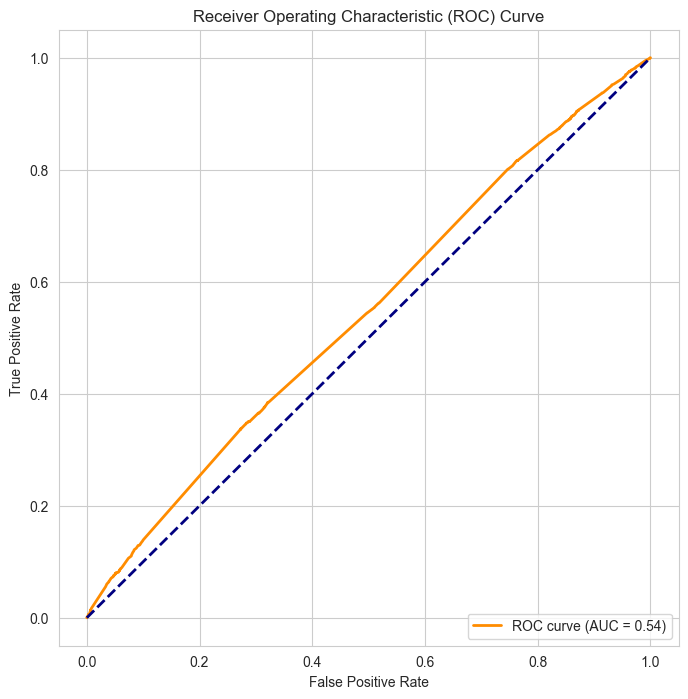

In [72]:
from sklearn.metrics import roc_curve, auc

# Step 7: Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test['event_column'], predicted_times)

# Step 8: Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [67]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, SimpleRNN, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model

# Assuming 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times
# 'longitudinal_data' is your original DataFrame with longitudinal information
longitudinal_data = filtered_data

# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(longitudinal_data.drop(['event_column', 'time_column'], axis=1),
                                                    longitudinal_data[['event_column', 'time_column']],
                                                    test_size=0.2, random_state=42)

# Convert 'event_column' to boolean type
y_train['event_column'] = y_train['event_column'].astype(bool)
y_test['event_column'] = y_test['event_column'].astype(bool)

# Step 2: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Reshape input for RNN
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Step 4: Build the RNN model
input_layer = Input(shape=(X_train_scaled.shape[1], 1))
rnn_layer = SimpleRNN(384, activation='relu')(input_layer)
dense_layer = Dense(128, activation='relu')(rnn_layer)
output_layer = Dense(1, activation='linear')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 5: Train the model
history = model.fit(X_train_rnn, y_train['time_column'].values, epochs=10, batch_size=64,
                    validation_split=0.2, callbacks=[early_stopping])

# Step 6: Evaluate the model
predicted_times = model.predict(X_test_rnn).flatten()

# Concordance Index
result = concordance_index_censored(y_test['event_column'], y_test['time_column'], predicted_times)
print(f"Concordance Index: {result[0]:.3f}")


Epoch 1/10
623/623 [==============================] - 179s 286ms/step - loss: 4849906688.0000 - val_loss: 9512930.0000
Epoch 2/10
623/623 [==============================] - 185s 296ms/step - loss: 11669340.0000 - val_loss: 9511377.0000
Epoch 3/10
623/623 [==============================] - 185s 297ms/step - loss: 9548767.0000 - val_loss: 9493490.0000
Epoch 4/10
623/623 [==============================] - 194s 311ms/step - loss: 52981989376.0000 - val_loss: 9492475.0000
Epoch 5/10
623/623 [==============================] - 210s 337ms/step - loss: 9515948.0000 - val_loss: 9445263.0000
Epoch 6/10
623/623 [==============================] - 212s 341ms/step - loss: 9452174.0000 - val_loss: 9352341.0000
Epoch 7/10
623/623 [==============================] - 211s 338ms/step - loss: 9569644.0000 - val_loss: 9335027.0000
Epoch 8/10
623/623 [==============================] - 195s 313ms/step - loss: 9372752.0000 - val_loss: 9319865.0000
Epoch 9/10
623/623 [==============================] - 201s 323ms

In [87]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

# Assuming 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times
# 'filtered_data' is your original DataFrame

# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data.drop(['event_column', 'time_column'], axis=1),
                                                    filtered_data[['event_column', 'time_column']],
                                                    test_size=0.2, random_state=42)

# Convert 'event_column' to boolean type
y_train['event_column'] = y_train['event_column'].astype(bool)
y_test['event_column'] = y_test['event_column'].astype(bool)

# Step 2: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Build the DeepSurv model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(386, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01),
                          input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer with linear activation for survival analysis
])

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0025)  # Adjust the learning rate

model.compile(optimizer=optimizer, loss='mean_squared_error')  # Using mean squared error as a loss for survival analysis

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 4: Train the model
history = model.fit(X_train_scaled, y_train['time_column'].values, epochs=10, batch_size=64,
                    validation_split=0.2, callbacks=[early_stopping])

# Step 5: Evaluate the model
predicted_times = model.predict(X_test_scaled).flatten()

# Concordance Index
result = concordance_index_censored(y_test['event_column'], y_test['time_column'], predicted_times)
print(f"Concordance Index: {result[0]:.3f}")


Epoch 1/10
623/623 [==============================] - 2s 3ms/step - loss: 9042695.0000 - val_loss: 7957703.0000
Epoch 2/10
623/623 [==============================] - 2s 3ms/step - loss: 6352357.5000 - val_loss: 4855883.0000
Epoch 3/10
623/623 [==============================] - 2s 3ms/step - loss: 3946417.2500 - val_loss: 3337387.2500
Epoch 4/10
623/623 [==============================] - 2s 3ms/step - loss: 3198626.2500 - val_loss: 3096465.5000
Epoch 5/10
623/623 [==============================] - 2s 3ms/step - loss: 3128372.5000 - val_loss: 3088668.7500
Epoch 6/10
623/623 [==============================] - 2s 3ms/step - loss: 3134543.2500 - val_loss: 3087337.5000
Epoch 7/10
623/623 [==============================] - 2s 3ms/step - loss: 3129575.5000 - val_loss: 3087949.5000
Epoch 8/10
623/623 [==============================] - 2s 2ms/step - loss: 3126469.5000 - val_loss: 3088948.2500
Epoch 9/10
623/623 [==============================] - 1s 2ms/step - loss: 3117193.5000 - val_loss: 30902

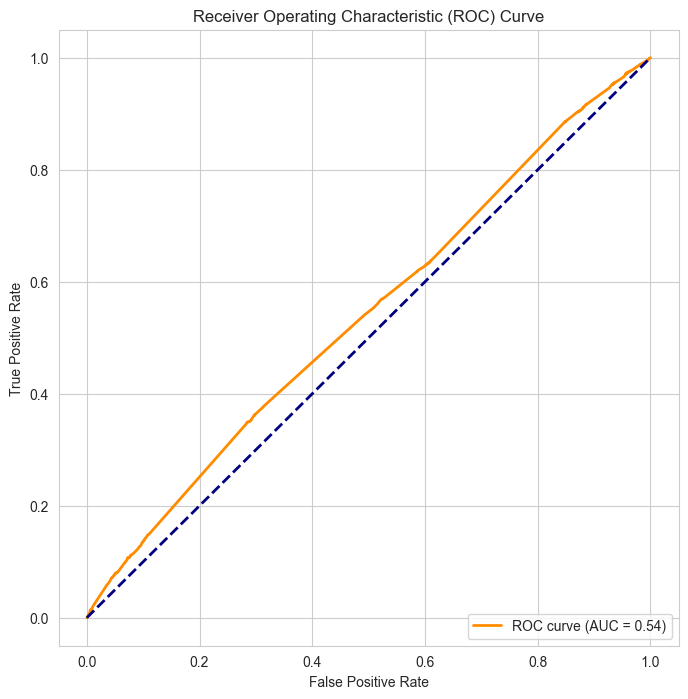

In [85]:
from sklearn.metrics import roc_curve, auc

# Step 7: Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test['event_column'], predicted_times)

# Step 8: Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

# Load or preprocess your dataset
# ...

# Assuming 'event_column' contains binary event indicators (0 or 1)
# 'time_column' contains survival times
# 'filtered_data' is your original DataFrame

# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    filtered_data.drop(['event_column', 'time_column'], axis=1),
    filtered_data[['event_column', 'time_column']],
    test_size=0.2, random_state=42
)

# Convert 'event_column' to boolean type
y_train_censored = Surv.from_arrays(y_train['event_column'], y_train['time_column'])
y_test_censored = Surv.from_arrays(y_test['event_column'], y_test['time_column'])

# Step 2: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Build Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X_train_scaled, y_train_censored)

# Step 4: Evaluate the model on the test set
predicted_survival_functions = rsf.predict_survival_function(X_test_scaled)

# Combine predicted survival functions (e.g., average) and evaluate performance
ensemble_predicted_times = pd.DataFrame(predicted_survival_functions).mean(axis=0)
result = concordance_index_censored(
    y_test['event_column'], y_test['time_column'], ensemble_predicted_times
)

print(f"Concordance Index (Ensemble): {result[0]:.3f}")


TypeError: unsupported operand type(s) for +: 'StepFunction' and 'StepFunction'

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = result_array.iloc[:, :-2]
y = result_array.iloc[:, -1]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestRegressor model (you can choose another algorithm based on your data)
model = RandomForestRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 2347871.1656680503


In [6]:
y.describe()

count    91139.000000
mean      2046.427029
std       1801.626218
min          0.000000
25%        486.000000
50%       1514.000000
75%       3209.000000
max       7680.000000
Name: 385, dtype: float64

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

X = result_array.iloc[:, :-2]
y = np.ceil(result_array.iloc[:, -1] / 365)

# Apply log transformation to the target variable
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)
y_log = log_transformer.fit_transform(y.values.reshape(-1, 1)).ravel()  # Use ravel() to flatten the target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Create a RandomForestRegressor model (or any other model of your choice)
model = RandomForestRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions_log = model.predict(X_test)

# Inverse transform the predictions to get them back in the original scale
predictions = log_transformer.inverse_transform(predictions_log.reshape(-1, 1)).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 14.301215316519984


In [31]:
predictions_surv['event']

array([False, False, False, ..., False, False, False])

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from lifelines.utils import concordance_index

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the c-index
c_index = concordance_index(y_test, -predictions)
print(f'C-Index: {c_index}')


Mean Squared Error: 14.301215316519984
C-Index: 0.33108905823175133
